<a href="https://colab.research.google.com/github/alxtyl/118B-FinalProject/blob/main/118B_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 1: Data Wrangling

Here, we import the speech of around 2,000 international English speakers. However, we only want the American English ones, and only roughly the first 10 seconds of speech. The goal of the data is to look like this: 

| Speaker | Speech File | Formant 1 | Formant 2 | Formant 3 | 

In [ ]:
#Install dependencies and import all packages along with dataset
!pip install praat-parselmouth
!pip install -U praat-parselmouth
!pip install hmmlearn
!curl -O http://164.92.77.249/speech.tar.gz
!tar -xf speech.tar.gz

from hmmlearn import base, hmm
from mpl_toolkits import mplot3d
from parselmouth import praat
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import csv
import parselmouth
import math

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 25  863M   25  216M    0     0  38.2M      0  0:00:22  0:00:05  0:00:17 42.5M

# Data Wrangling and Formant Extraction - Bridget

In [ ]:
Archive_Path = "SpeechArchive/"
reading_passage = Archive_Path + "reading-passage.txt"
with open(reading_passage, "r") as file1:
    FileContent = file1.read()
FileContent

'Please call Stella.  Ask her to bring these things with her from the store:  Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.  We also need a small plastic snake and a big toy frog for the kids.  She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.\n'

Here, we are just testing to be sure we can access the mp3 file. 

In [ ]:
file_name = 'english145.mp3'
example_audio = Archive_Path + '/recordings/recordings/' + file_name

x, sr = librosa.load(example_audio)
ipd.Audio(x, rate = sr)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Now that the audio is loaded in, we need to find the speakers that we want to analyze. Let's load it as a csv, and as a df, since I am indecisive.



In [ ]:
speaker_inf = Archive_Path + "speakers_all.csv"

rows = []
with open(speaker_inf, 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    for row in csvreader:
        rows.append(row)
print(header[:9])
print(rows[:1])

['age', 'age_onset', 'birthplace', 'filename', 'native_language', 'sex', 'speakerid', 'country', 'file_missing?']
[['24', '12', 'koussi, senegal', 'balanta', 'balanta', 'male', '788', 'senegal', 'TRUE', '', '', '']]


In [ ]:
speaker_df = pd.read_csv(speaker_inf)

As is the goal of the dataset, we just want native English speakers. (Only from America? I think having all the native speakers would be cool. )

In [ ]:
# native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english'])) & (speaker_df['country'].isin(['usa']))]
native_english_speakers = speaker_df.loc[(speaker_df['native_language'].isin(['english']))]
#weird unnamed columns b/c weird zip csv file?? dropt. periodt.
native_english_speakers = native_english_speakers.drop(['Unnamed: 9',	'Unnamed: 10',	'Unnamed: 11'], axis=1)


#strangely, this dataset only output 40 formants, not useful for comparison english 145, english317, english315, english450
native_english_speakers[348:398]
native_english_speakers = native_english_speakers.drop([414,603,605,753])
native_english_speakers = native_english_speakers.reset_index()
# native_english_speakers[210:250]


#drop english145

native_english_speakers.shape

(575, 10)

And now we have the names for all the files: 

In [ ]:
native_english_files = native_english_speakers['filename']
native_english_files.shape

(575,)

So now we are able to begin feature extraction for the relevant audio files, which will be the first three formants. 

In [ ]:
example_aud = Archive_Path + 'recordings/recordings/english1.mp3'
print(example_aud)

SpeechArchive/recordings/recordings/english1.mp3


In [ ]:
# ala http://blog.syntheticspeech.de/2021/03/10/how-to-extract-formant-tracks-with-praat-and-python/
def acquire_formants(file_path):
  f1_list, f2_list, f3_list  = [], [], []

  f0min, f0max  = 75, 300
  sec_limit = 15
  sound = parselmouth.Sound.extract_part(parselmouth.Sound(file_path) , 0, sec_limit)
  pointProcess = praat.call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
  numPoints = praat.call(pointProcess, "Get number of points")
  
  formants = praat.call(sound, "To Formant (burg)", 0.005, 5, 5500, 0.025, 50)
  # print("Sample Points:", str(sound.n_samples))
  # print("Num:", str(numPoints))

  for point in range(0, numPoints):
      point += 1
      t = praat.call(pointProcess, "Get time from index", point)
      f1 = praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
      f2 = praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
      f3 = praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
      f1_list.append(f1)
      f2_list.append(f2)
      f3_list.append(f3)
    
  return f1_list, f2_list, f3_list

In [ ]:
# acquire_formants(Archive_Path + 'recordings/recordings/' + 'english145.mp3')

In [ ]:
def add_formants(native_english_files, df):
  
  f1, f2, f3 = [],[],[]
  count = 0 
  file_count = len(native_english_files) 

  min_len = 10000
  for speaker_file in native_english_files: 
    count += 1
    file_path = Archive_Path + 'recordings/recordings/' + speaker_file + '.mp3'
    
    formants = acquire_formants(file_path)
    
    print(speaker_file, "done.", count, "of", file_count, "complete!")
    
    f1.append(formants[0])
    f2.append(formants[1])
    f3.append(formants[2])

    len_f1, len_f2, len_f3 = len(formants[0]), len(formants[1]), len(formants[2])

    speaker_min = min(len_f1, len_f2, len_f3)

    if speaker_min < min_len: 
      min_len = speaker_min 
      print("min_len update:", speaker_file, ":", min_len)

  for i in range(len(f1)): 
    min_len = min_len
    f1[i] = f1[i][:min_len]
    f2[i] = f2[i][:min_len]
    f3[i] = f3[i][:min_len]

  for speaker_file in native_english_files: 
    df['f1'] = f1
    df['f2'] = f2
    df['f3'] = f3

  return df

#test: 
nes_first_3 = native_english_speakers.head(3)
# native_english_files[:3]
test_3 = add_formants(native_english_files[:3], nes_first_3)

english1 done. 1 of 3 complete!
min_len update: english1 : 592
english10 done. 2 of 3 complete!
english100 done. 3 of 3 complete!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
test_3['f1'].str.len()

0    592
1    592
2    592
Name: f1, dtype: int64

In [ ]:
# run to regen nes
# native_english_speakers = add_formants(native_english_files, native_english_speakers)

Grab the pickle files off the server

In [ ]:
!curl -O http://164.92.77.249/native_english.pck
!curl -O http://164.92.77.249/native_english_clipped394.pck

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  14.1M      0 --:--:-- --:--:-- --:--:-- 14.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6028k  100 6028k    0     0  8587k      0 --:--:-- --:--:-- --:--:-- 8587k


In [ ]:
#native_english_speakers = pd.read_pickle("/content/drive/MyDrive/native_english.pck")
native_english_speakers = pd.read_pickle("native_english.pck")

#native_english_speakers_clip = pd.read_pickle("/content/drive/MyDrive/native_english_clipped394.pck")
native_english_speakers_clip = pd.read_pickle("native_english_clipped394.pck")

native_english_speakers_clip.shape

(575, 13)

In [ ]:
native_english_speakers.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.21766592628603, 383.3048603159792, 375.73...","[2146.197420848668, 2265.073676608922, 2238.96...","[2526.155130504279, 2580.1540708955213, 2610.8..."
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.791572791465, 333.5406503005196, 358.1649...","[1974.9033700266357, 2084.588564208539, 2124.4...","[2853.4023216197447, 2889.707512237676, 2857.9..."
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[313.11571323002556, 293.7516378968984, 291.04...","[837.2749761154321, 998.0551739573779, 1028.83...","[1309.0288192622993, 1290.5245752384428, 1285...."
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3027180808342, 402.10113594759747, 443.54...","[1610.8220469527037, 1729.9302654331407, 1802....","[2926.824953545606, 3045.423389665372, 3216.60..."
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.16943505125215, 396.30873727164476, 387.7...","[1172.411118682909, 1237.7783779601746, 1354.2...","[2986.2940891488297, 2949.1760833289895, 2712...."


Splitting the data into men and women, since it is true that men's formant values will generally be lower than women's, for clustering later. And making a df for only usa


In [ ]:
nes_wom = native_english_speakers[native_english_speakers['sex'] == 'female']
nes_men = native_english_speakers[native_english_speakers['sex'] == 'male']

nes_wom_clip = native_english_speakers_clip[native_english_speakers_clip['sex'] == 'female']
nes_men_clip = native_english_speakers_clip[native_english_speakers_clip['sex'] == 'male']

nes_wom_clip_usa = nes_wom_clip[nes_wom_clip['country'] == 'usa']
nes_men_clip_usa = nes_men_clip[nes_men_clip['country'] == 'usa']

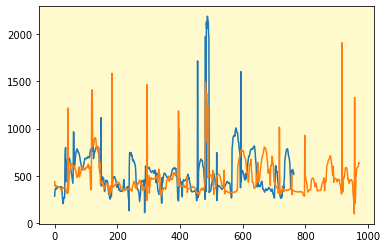

In [ ]:
speak364 = np.array(native_english_speakers.at[364, 'f1'])
speak500 = np.array(native_english_speakers.at[500, 'f1'])
plt.plot(speak364)
plt.plot(speak500);

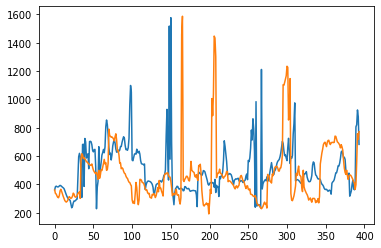

In [ ]:
speak364_clip = np.array(native_english_speakers_clip.at[364, 'f1'])
speak500_clip = np.array(native_english_speakers_clip.at[500, 'f1'])
plt.plot(speak364_clip)
plt.plot(speak500_clip);

In [ ]:
nes_men_clip.head()

,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3
0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888..."
4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7..."
5,368,21.0,0.0,"staten island, new york, usa",english103,english,male,66,usa,False,"[269.5861431948941, 340.4010965355361, 334.618...","[1205.9780100044734, 1397.2832730031703, 1567....","[2671.604922027467, 2668.797234114747, 2633.12..."
7,370,57.0,0.0,"windsor, ontario, canada",english105,english,male,407,canada,False,"[722.7066762392138, 489.36106049747855, 447.79...","[2472.697784017536, 1034.6829637259643, 1096.1...","[3744.9163882713224, 2656.652148500367, 2544.8..."
9,372,19.0,0.0,"chicago, illinois, usa",english107,english,male,416,usa,False,"[1197.231143755197, 1128.0643819940615, 530.12...","[2598.680493153703, 2558.291455196927, 1566.69...","[3476.2290816147097, 3852.316827455011, 3012.3..."


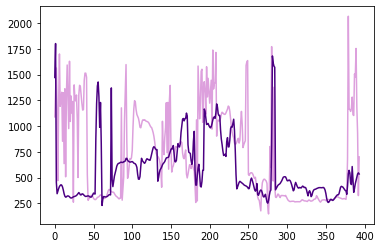

In [ ]:
wom_speak366 = np.array(nes_wom_clip.at[366, 'f1'])
wom_speak367 = np.array(nes_wom_clip.at[367, 'f1'])
plt.plot(wom_speak366, 'plum')
plt.plot(wom_speak367, 'indigo')

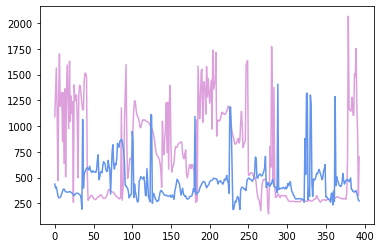

In [ ]:
man_speak372 = np.array(nes_men_clip.at[372, 'f1'])
plt.plot(wom_speak366, color = 'plum')
plt.plot(man_speak372, color = 'cornflowerblue')

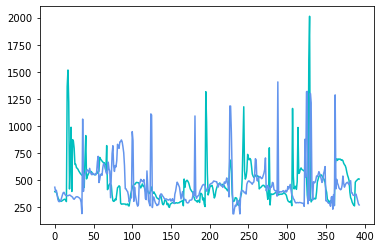

In [ ]:
man_speak374 = np.array(nes_men_clip.at[4, 'f1'])
plt.plot(man_speak374, color = 'c')
plt.plot(man_speak372, color = 'cornflowerblue')

# Cross-Correlation - Donovan

Ideal shift for alignment:
49


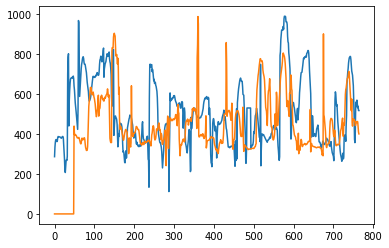

In [ ]:
#Just some correlation testing
def patch_invalid(x):
  for i in range(1, len(x)):
    if math.isnan(x[i]):
      x[i] = x[i-1]
  return x

def resample_to_length(audio, length):
  audio = patch_invalid(audio)
  interp_domain = np.linspace(0, len(audio), length)
  return np.interp(interp_domain, np.arange(0, len(audio)), audio)

#returns the ideal shift to match the offset of file_a
def cross_corr(file_a, file_b):
  #largest allowed offset to shift the datapoints
  MAX_SHIFT = 50
  dat1_m = file_a - np.mean(file_a)
  dat2_m = file_b - np.mean(file_b)
  min_index = len(dat1_m) - MAX_SHIFT
  max_index = len(dat1_m) + MAX_SHIFT
  #find the maximum correlation from within (-MAX_SHIFT, +MAX_SHIFT)
  shift = np.argmax(np.correlate(dat1_m, dat2_m, mode='full')[min_index:max_index]) - MAX_SHIFT
  return shift

def apply_shift(audio, shift):
  audio = np.roll(audio, shift)
  if shift > 0:
    audio[0:shift] = np.mean(audio)
  else:
    audio[shift:] = np.mean(audio)
  
  return audio

AUDIO_LEN = 394

#grab the standard snippet to correlate the rest to:
ideal = native_english_speakers.iloc[0]
ideal_corr = resample_to_length(np.array(ideal.f1), AUDIO_LEN)

#compute adjusted dataframe
f1_corr, f2_corr, f3_corr = [], [], []
shifts = []
for i, row in native_english_speakers.iterrows():
  f1 = resample_to_length(np.array(row.f1), AUDIO_LEN)
  shift = cross_corr(ideal_corr, f1)
  shifts.append(shift)
  f1_corr.append(apply_shift(f1, shift))
  f2_corr.append(apply_shift(resample_to_length(row.f2, AUDIO_LEN), shift))
  f3_corr.append(apply_shift(resample_to_length(row.f3, AUDIO_LEN), shift))
  print(f"applied shift of {shift} to row {i}")

english_corr = native_english_speakers.copy(deep=True)
english_corr['f1'] = f1_corr
english_corr['f2'] = f2_corr
english_corr['f3'] = f3_corr
plt.plot(english_corr.loc[638, 'f1'])
plt.plot(english_corr.loc[638, 'f2'])

Ideal shift for alignment:
18


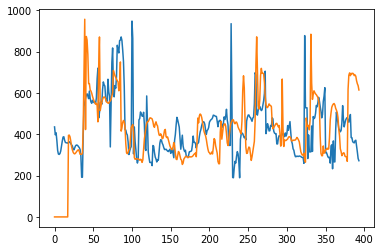

In [ ]:
cross_corr(man_speak372, man_speak374)

Ideal shift for alignment:
6


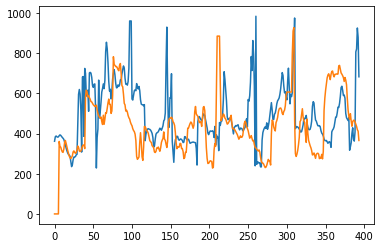

In [ ]:
cross_corr(speak364_clip, speak500_clip) 

In [ ]:
native_english_speakers;

In [ ]:
def mean_df(df):
  mean_data = pd.DataFrame(columns=['f1', 'f2', 'f3'])

  for idx, rows in df.iterrows():
    f_1 = [x for x in rows['f1'] if np.isnan(x) == False]
    f_2 = [y for y in rows['f2'] if np.isnan(y) == False]
    f_3 = [z for z in rows['f3'] if np.isnan(z) == False]
    
    mean_1 = np.mean(f_1)
    mean_2 = np.mean(f_2)
    mean_3 = np.mean(f_3)

    mean_data.at[idx, 'f1'] = mean_1
    mean_data.at[idx, 'f2'] = mean_2
    mean_data.at[idx, 'f3'] = mean_3 

  return mean_data 

In [ ]:
mean_data = mean_df(native_english_speakers)

mean_wom = mean_df(nes_wom_clip)
mean_men = mean_df(nes_men_clip)

mean_wom_usa = mean_df(nes_wom_clip_usa)
mean_men_usa = mean_df(nes_men_clip_usa)

In [ ]:
mean_men.shape

(305, 3)

In [ ]:
mean_men_usa.shape

(187, 3)

In [ ]:
mean_data.shape

(579, 3)

In [ ]:
#getting rid some of the outliers
f12_df = mean_data[['f1', 'f2']]

In [ ]:
f12_df_men = mean_men[['f1', 'f2']]
f12_df_wom = mean_wom[['f1', 'f2']]

f12_df_men_usa = mean_men_usa[['f1', 'f2']]
f12_df_wom_usaa = mean_wom_usa[['f1', 'f2']]

In [ ]:
f12_df = f12_df[(f12_df['f1'] <= 1250) & (f12_df['f2'] <= 2350)]
f12_df.max()

f1    1248.410638
f2    2276.193613
dtype: object

In [ ]:
mean_data.head()

,f1,f2,f3
363,547.496854,1708.859646,2663.916543
364,530.511878,1803.938875,2750.757498
365,384.03308,1692.323742,2972.540686
366,497.698778,1889.913689,2955.618529
367,448.085294,1464.683065,2646.339135


Gonna visualize the f1, f2, and f3

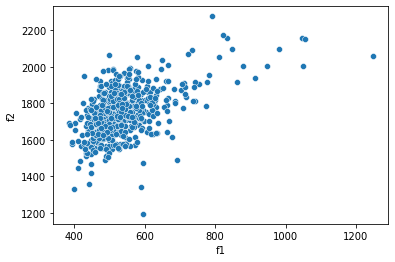

In [ ]:
# F1 and F2
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df)

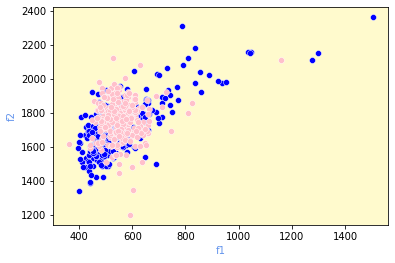

In [ ]:
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_men, color = 'blue')
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_wom, color = 'pink');

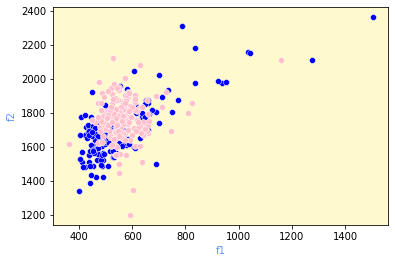

In [ ]:
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_men_usa, color = 'blue')
sns.scatterplot(x = 'f1', y = 'f2', data = f12_df_wom_usaa, color = 'pink');

# PCA - Donovan


(575, 1182)


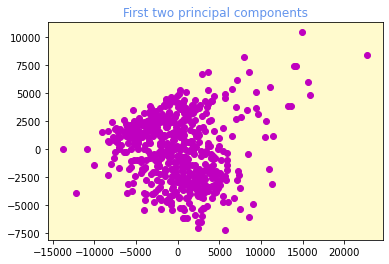

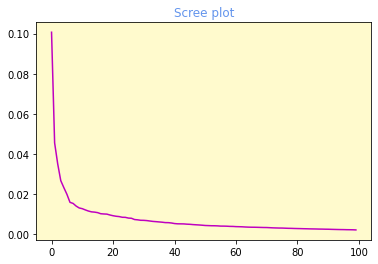

In [ ]:
#wrangling nonsense to get dataframe into a numpy array
#each formant is concatenated together into the same column
def PCA_plot(df, color = 'm'): 
  selectf1 = df[['f1']]
  selectf2 = df[['f2']]
  selectf3 = df[['f3']]
  npself1 = selectf1.to_numpy().reshape((len(selectf1),))
  npself1_2d = np.array(list(npself1))
  npself2 = selectf2.to_numpy().reshape((len(selectf2),))
  npself2_2d = np.array(list(npself2))
  npself3 = selectf3.to_numpy().reshape((len(selectf3),))
  npself3_2d = np.array(list(npself3))
  total_np_data = np.concatenate((npself1_2d, npself2_2d, npself3_2d), axis=1)

  #remove a handful of nan/inf
  total_np_data[~np.isfinite(total_np_data)] = 0
  print(total_np_data.shape)


  pca_var = PCA(n_components=100)
  pca_df = pca_var.fit_transform(total_np_data)
  plt.title("First two principal components")
  plt.scatter(pca_df[:,0], pca_df[:,1], color = color)
  plt.figure(color)
  plt.title("Scree plot")
  plt.plot(pca_var.explained_variance_ratio_, color)

  return pca_df

pca_df  = PCA_plot(native_english_speakers_clip)


#TODO: Use regions for coloring points in the plot, see if there is some structure

(305, 1182)


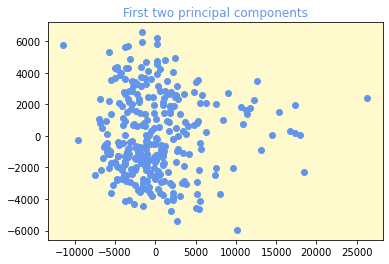

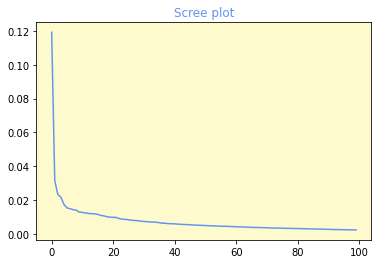

In [ ]:
pca_df_men = PCA_plot(nes_men_clip, 'cornflowerblue')

(270, 1182)


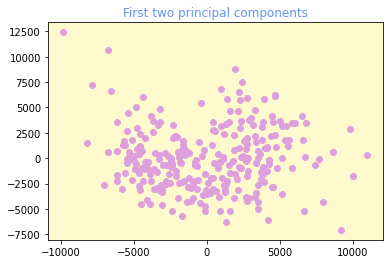

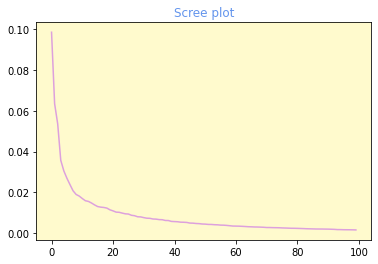

In [ ]:
pca_df_wom = PCA_plot(nes_wom_clip, 'plum')

(187, 1182)


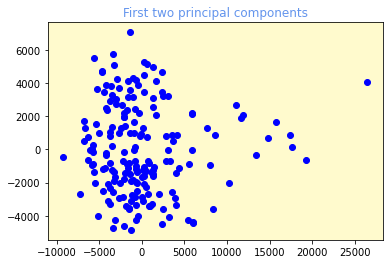

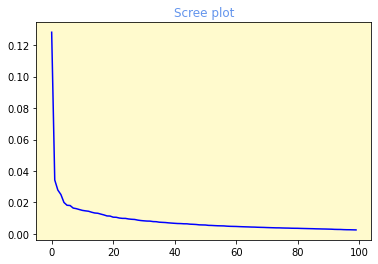

In [ ]:
pca_df_men_usa = PCA_plot(nes_men_clip_usa, 'cornflowerblue')

(184, 1182)


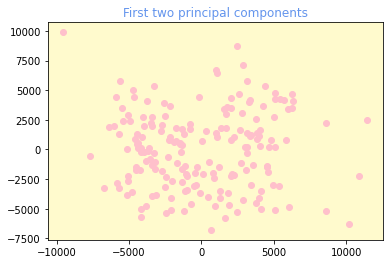

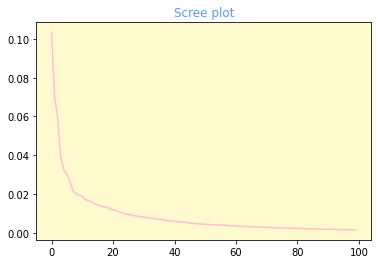

In [ ]:
pca_df_wom_usa = PCA_plot(nes_wom_clip_usa, 'plum')

# K-Means - Aryaman


In [ ]:
colors = ['crimson', 'deeppink', 'palevioletred', 'lightpink', 'mediumpurple', 'rebeccapurple', 'plum', 'mediumturquoise', 'thistle', 'firebrick', 'mediumslateblue', 'lightcoral', 'orchid']
m_col = ['mediumturquoise', 'thistle', 'firebrick', 'mediumslateblue', 'lightcoral', 'orchid', 'teal', 'dodgerblue', 'aquamarine', 'navy', 'goldenrod', 'olivedrab', 'paleturquoise', 'seagreen']
w_col = ['plum', 'm', 'deeppink', 'crimson', 'darkviolet', 'darkslateblue', 'slateblue', 'blueviolet', 'crimson', 'deeppink', 'palevioletred', 'lightpink', 'mediumpurple', 'rebeccapurple', 'cornflowerblue' ]

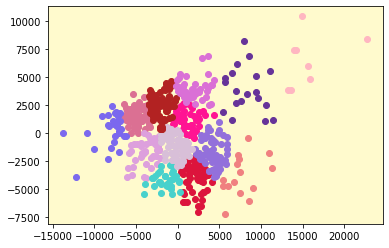

In [ ]:
#Using first 2 principal components
def kmeans(df, colors, n_clusters): 
  component_1 = df[:,0]
  component_2 = df[:,1]
  X = [[component_1[i], component_2[i]] for i in range(len(component_1))]
  kmeans = KMeans(n_clusters).fit(X)
  kmeans_df = pd.DataFrame({'component_1' : component_1, 'component_2' : component_2, 'cluster_assignment': kmeans.labels_})
  plt.rcParams.update({'axes.facecolor':'lemonchiffon'})
  plt.rcParams.update({'text.color' : "cornflowerblue",'axes.labelcolor' : "cornflowerblue"})
  plt.figure(facecolor='white') 

  for i in range(n_clusters): 
    plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:,0] , kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:, 1] , color = colors[i])

  plt.show()
  return kmeans_df

kmeans_df = kmeans(pca_df, colors, 13)

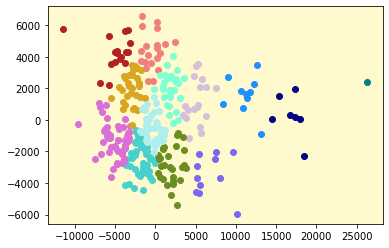

In [ ]:
kmeans_df_men = kmeans(pca_df_men, m_col, 13)

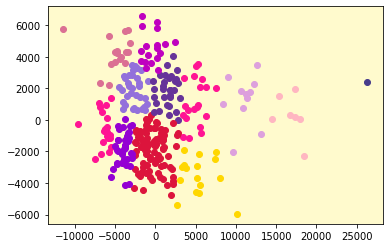

In [ ]:
kmeans_df_wom = kmeans(pca_df_men, w_col,13)

In [ ]:
kmeans_df.cluster_assignment.value_counts()

2     78
6     77
5     64
1     60
11    49
9     47
10    46
3     42
0     40
8     31
4     18
7     15
12     8
Name: cluster_assignment, dtype: int64

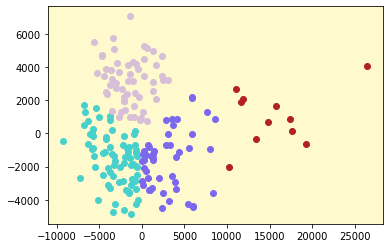

In [ ]:
kmeans_df_men_usa = kmeans(pca_df_men_usa, m_col, 4)

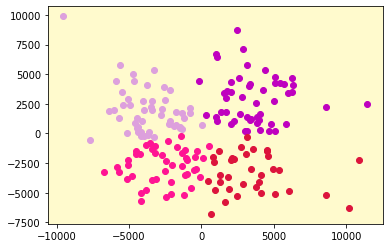

In [ ]:
kmeans_df_wom_usa = kmeans(pca_df_wom_usa, w_col, 4)

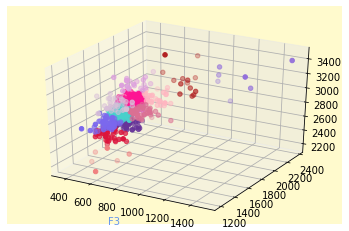

In [ ]:
def kmeans3d(df, colors, n_clusters): 
  f1_means = df['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f2_means = df['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f3_means = df['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
  
  kmeans_3d = KMeans(n_clusters).fit(X)
  temp_df = pd.DataFrame({'f1_means': f1_means, 'f2_means': f2_means, 'f3_means': f3_means, 'cluster': kmeans_3d.labels_})
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  for i in range(0,n_clusters): 
    ax.scatter(temp_df.loc[temp_df.cluster == i].iloc[:, 0], temp_df.loc[temp_df.cluster == i].iloc[:, 1], temp_df.loc[temp_df.cluster == i].iloc[:, 2], color = colors[i])

  ax.set_xlabel('F1')
  ax.set_xlabel('F2')
  ax.set_xlabel('F3')
  plt.show()
  return temp_df

temp_df = kmeans3d(native_english_speakers_clip, colors, 13)

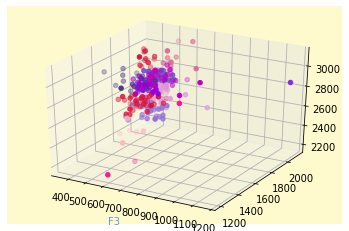

''

In [ ]:
kmeans3d(nes_wom_clip, w_col, 13);

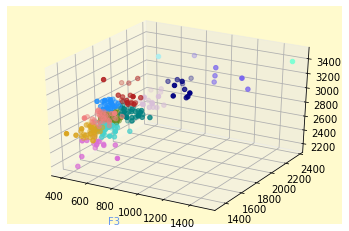

In [ ]:
kmeans3d(nes_men_clip, m_col, 13);

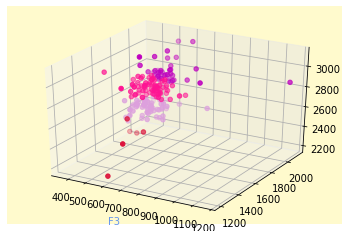

In [ ]:
kmeans3d(nes_wom_clip_usa, w_col, 4);

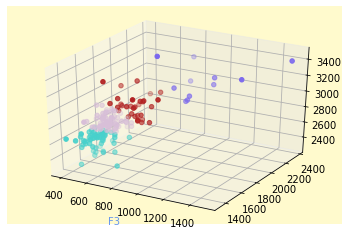

In [ ]:
kmeans3d(nes_men_clip_usa, m_col, 4);

In [ ]:
temp_df.cluster.value_counts()

0    153
3    139
2    136
4    127
1     20
Name: cluster, dtype: int64

# GHMM - Dong


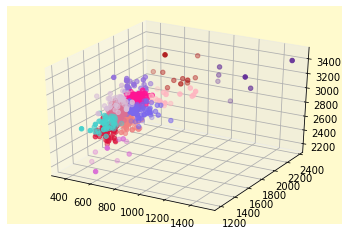

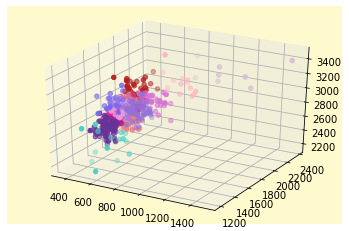

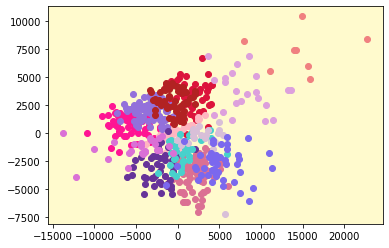

In [ ]:
from librosa.core.notation import thaat_to_degrees
# how many clusters do we want to be dtermined later
# focusing on f1, f2, f3 I am assuming but right now using the f1 and f2 to get used of using the HMM

def GHMM(nes, pca_df, clusters, threeD = False, colors = colors): 
  comp_1 = pca_df[:,0]
  comp_2 = pca_df[:,1]

  f1_means = nes['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f2_means = nes['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  f3_means = nes['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
  pca_com_12 = [[comp_1[i], comp_2[i]] for i in range(len(comp_1))]

  model = hmm.GaussianHMM(n_components= clusters)
  PCA_HMM = model.fit(pca_com_12)
  hidden_states = PCA_HMM.predict(pca_com_12)
  model2 = hmm.GaussianHMM(n_components= clusters)
  X = [[f1_means[i], f2_means[i], f3_means[i]] for i in range(len(f1_means))]
  mean_HMM = model2.fit(X)
  states = mean_HMM.predict(X)
  HMM_df = pd.DataFrame({'component_1' : comp_1, 'component_2' : comp_2, 'cluster_assignment': hidden_states})

  HMM3D_df = pd.DataFrame({'f1' : f1_means, 'f2' : f2_means, 'f3' : f3_means, 'cluster': states})
  fig2 = plt.figure()
  kx = fig2.add_subplot(projection='3d')


  for i in range(clusters):
    kx.scatter(HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 0], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 1], HMM3D_df.loc[HMM3D_df.cluster == i].iloc[:, 2], color = colors[i])
  plt.show()
  # display(fig2)

  if threeD: 
    return HMM3D_df

  if not threeD: 
    return HMM_df

HMM3D_df = GHMM(native_english_speakers_clip, pca_df, 13, threeD = True)
GHMM3d_df = GHMM(native_english_speakers_clip, pca_df, 13, threeD = False)
GHMM3d_df.cluster_assignment.value_counts()

clusters = 13
for i in range(clusters):
  plt.scatter(GHMM3d_df.loc[GHMM3d_df.cluster_assignment == i].iloc[:, 0] , GHMM3d_df.loc[GHMM3d_df.cluster_assignment == i].iloc[:, 1], color = colors[i])

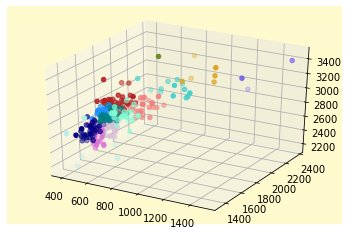

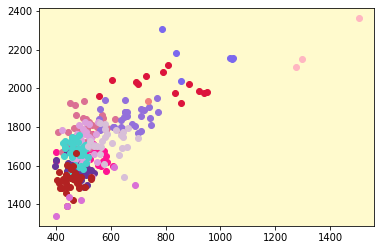

In [ ]:
GHMM3d_df_men = GHMM(nes_men_clip, pca_df_men, 13, threeD = True, colors = m_col)
GHMM3d_df_men.cluster.value_counts()
for i in range(clusters):
  plt.scatter(GHMM3d_df_men.loc[GHMM3d_df_men.cluster == i].iloc[:, 0] , GHMM3d_df_men.loc[GHMM3d_df_men.cluster == i].iloc[:, 1], color = colors[i])

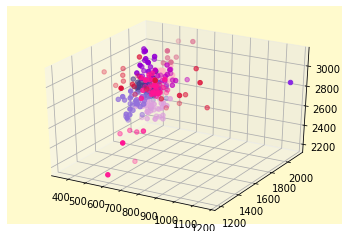

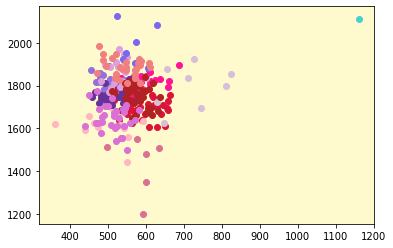

In [ ]:
GHMM3d_df_wom = GHMM(nes_wom_clip, pca_df_wom, 13, threeD = True, colors = w_col)
GHMM3d_df_wom.cluster.value_counts()

for i in range(clusters):
  plt.scatter(GHMM3d_df_wom.loc[GHMM3d_df_wom.cluster == i].iloc[:, 0] , GHMM3d_df_wom.loc[GHMM3d_df_wom.cluster == i].iloc[:, 1], color = colors[i])

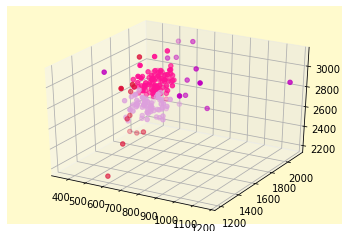

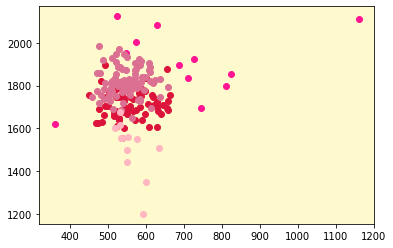

In [ ]:
GHMM3d_df_wom_usa = GHMM(nes_wom_clip_usa, pca_df_wom_usa, 4, threeD=True, colors = w_col)
GHMM3d_df_wom_usa.cluster.value_counts()


clusters = 4
for i in range(clusters):
  plt.scatter(GHMM3d_df_wom_usa.loc[GHMM3d_df_wom_usa.cluster == i].iloc[:, 0] , GHMM3d_df_wom_usa.loc[GHMM3d_df_wom_usa.cluster == i].iloc[:, 1], color = colors[i])

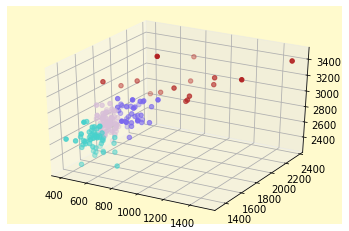

187


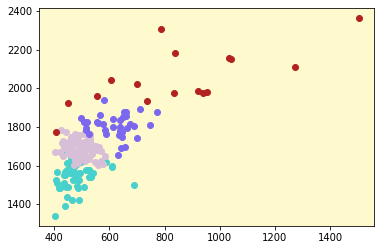

In [ ]:
GHMM3d_df_men_usa = GHMM(nes_men_clip_usa, pca_df_men_usa, 4, threeD=True, colors = m_col)
GHMM3d_df_men_usa.cluster.value_counts()

print(GHMM3d_df_men_usa.cluster.size)

clusters = 4
for i in range(clusters):
  plt.scatter(GHMM3d_df_men_usa.loc[GHMM3d_df_men_usa.cluster == i].iloc[:, 0] , GHMM3d_df_men_usa.loc[GHMM3d_df_men_usa.cluster == i].iloc[:, 1], color = m_col[i])

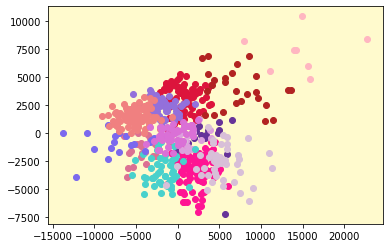

In [ ]:
# HMM3D_df = pd.DataFrame({'f1' : mean_data.f1.values.tolist(), 'f2' : mean_data.f2.values.tolist(), 'f3' : mean_data.f2.values.tolist(), 'cluster': states})
f1_means = native_english_speakers_clip['f1'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f2_means = native_english_speakers_clip['f2'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()
f3_means = native_english_speakers_clip['f3'].apply(lambda x: pd.Series(x).dropna().mean()).tolist()

# Accuracy Testing - Jake and Alex

In [ ]:
new_speaker_df = native_english_speakers_clip.reset_index()
HMM3D_df

new_speaker_df['cluster'] = HMM3D_df['cluster']
new_speaker_df

,level_0,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,cluster
0,0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",8
1,1,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.78034366393695, 333.54027986877463, 358.2...","[1974.7398866094045, 2084.5578055165697, 2124....","[2853.2928088694052, 2889.6240622315777, 2857....",5
2,2,365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[312.9781514843358, 293.60305965141947, 290.88...","[837.3376620186896, 993.2380910061022, 1023.86...","[1309.120766111249, 1290.5791719544743, 1285.8...",9
3,3,366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3056496833393, 402.106152536091, 443.5521...","[1610.8457576851163, 1730.00458789682, 1802.83...","[2926.867159255761, 3045.4127116240597, 3216.4...",11
4,4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,570,937,18.0,0.0,"mishawaka, indiana, usa",english95,english,male,160,usa,False,"[225.37493141298384, 429.2322347330008, 391.57...","[1156.3249709505758, 1244.426330722122, 1320.0...","[2508.9895440671307, 2484.205074689459, 2496.1...",0
571,571,938,31.0,0.0,"point pleasant, new jersey, usa",english96,english,male,161,usa,False,"[387.73587571581527, 294.2607926137612, 332.01...","[1685.3000465157481, 1670.8185592715527, 1705....","[2941.646285834069, 2376.5823506980514, 2429.0...",5
572,572,939,42.0,0.0,"wilmington nc, north carolina, usa",english97,english,male,162,usa,False,"[1233.2597285111324, 1676.7783128168037, 1601....","[2203.0919270175045, 1963.970939316393, 1760.4...","[3265.9801038036912, 2595.619642668225, 2386.0...",6
573,573,940,22.0,0.0,"spokane, washington, usa",english98,english,male,163,usa,False,"[290.1602083589574, 301.000151798266, 299.4749...","[1263.876121389454, 1295.0817944345456, 1370.1...","[2635.912026875992, 2791.161318002734, 2724.55...",0


In [ ]:
#Making sure hmm3d_df means align with native_english_speakers so we can start cross referencing
speaker_1_f1 = new_speaker_df.iloc[0]['f1']
speaker_1_f1 = [x for x in speaker_1_f1 if np.isnan(x) == False]
np.mean(speaker_1_f1)

563.3245301929626

In [ ]:
#Time to generalize locations
the_west = ["washington", "oregon", "california", "idaho", "utah", "montana", "colorado", "nevada", "arizona", "new mexico", "alaska", "hawaii", "wyoming"] 
the_midwest =  ["north dakota", "south dakota", "nebraska", "kansas",  "wisconsin", "minnesota", "illinois", "missouri", "indiana", "michigan", "iowa", "ohio", "pennsylvania"] 
the_south = ["west virginia", "kentucky", "oklahoma", "texas", "tennessee", "mississippi", "georgia", "alabama", "arkansas", "florida", "south carolina", "north carolina", "louisiana"] 
the_north = ['va', "new york", "maryland", "delaware", "virginia", "maine", "new hampshire", "vermont", "massachusetts", "rhode island", "connecticut", "new jersey"]

the_carribbean = ['us virgin islands', 'jamaica', 'barbados', 'the bahamas', 'antigua and barbuda', 'trinidad']
south_pacific = ['fiji', 'malaysia', 'philippines', 'singapore'] 
c_and_south_america = ['guyana', 'panama', 'belize', 'bolivia'] 
west_africa = ['liberia', 'nigeria', 'ghana']
uk = ['uk', 'isle of man', 'ireland']
germanic_europe = ['germany', 'switzerland']
romantic_europe = ['italy', 'spain']
m_east = ['lebanon', 'united arab emirates', 'pakistan', ] 
oceania = ['australia', 'new zealand', 'papua new guinea']

def regionalize(df): 
  region = []
  for strng in new_speaker_df['birthplace']:
    strng_country = str(strng.split(',')[-1]).strip()

    if strng_country == 'usa': 
      # region.append('US')
      if any(state in strng for state in the_north) or strng_country == 'virginia':
        region.append('the_north')
      elif any(state in strng for state in the_west):
        region.append('the_west')
      elif any(state in strng for state in the_midwest):
        region.append('the_midwest')
      elif any(state in strng for state in the_south):
        region.append('the_south')
      else:
        region.append('no_assignment')
        print(strng)

    else: 
      if strng_country == 'canada':
        region.append('Canada')
      elif strng_country in the_carribbean:
        region.append('Caribbean')
      elif strng_country in south_pacific:
        region.append('South Pacific')
      elif strng_country in c_and_south_america:
        region.append('Central or South America')
      elif strng_country in west_africa:
        region.append('West Africa')
      elif strng_country in uk:
        region.append('UK')
      elif strng_country in germanic_europe:
        region.append('Germanic Europe')
      elif strng_country in romantic_europe:
        region.append('Romantic Europe')
      elif strng_country in m_east:
        region.append('Middle East')
      elif strng_country in oceania:
        region.append('Oceania')
      elif strng_country == 'india':
        region.append('India')
      elif strng_country == 'south africa':
        region.append('South Africa')
      else:
        region.append('no assignment')
        # print(strng_country)

  new_speaker_df['region'] = region
  return new_speaker_df

new_speaker_df = regionalize(new_speaker_df)
new_speaker_df.head()

,level_0,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,cluster,region
0,0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",1,the_north
1,1,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.78034366393695, 333.54027986877463, 358.2...","[1974.7398866094045, 2084.5578055165697, 2124....","[2853.2928088694052, 2889.6240622315777, 2857....",1,the_midwest
2,2,365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[312.9781514843358, 293.60305965141947, 290.88...","[837.3376620186896, 993.2380910061022, 1023.86...","[1309.120766111249, 1290.5791719544743, 1285.8...",11,the_south
3,3,366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3056496833393, 402.106152536091, 443.5521...","[1610.8457576851163, 1730.00458789682, 1802.83...","[2926.867159255761, 3045.4127116240597, 3216.4...",4,Canada
4,4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",8,the_north


In [ ]:
new_wom_df = nes_wom_clip.reset_index()
new_wom_df['cluster'] = HMM3D_df['cluster']

In [ ]:
new_men_df = nes_wom_clip.reset_index()
new_men_df = native_english_speakers_clip.reset_index()

In [ ]:
new_speaker_df[new_speaker_df['cluster'] == 1]['region'].value_counts()

the_north                   15
Canada                       7
the_west                     7
the_midwest                  6
UK                           4
the_south                    4
Middle East                  3
Central or South America     2
Oceania                      1
Germanic Europe              1
Name: region, dtype: int64

In [ ]:
new_speaker_df[new_speaker_df['cluster'] == 2]['region'].value_counts()

UK             3
Canada         3
Oceania        2
the_south      2
the_west       2
the_north      2
the_midwest    1
Name: region, dtype: int64

In [ ]:
new_speaker_df[new_speaker_df['cluster'] == 3]['region'].value_counts()

the_midwest        6
the_north          5
the_west           2
UK                 2
the_south          2
Caribbean          1
Romantic Europe    1
Name: region, dtype: int64

In [ ]:
new_speaker_df[new_speaker_df['cluster'] == 4]['region'].value_counts()

UK               14
the_north        13
the_west         12
the_south         8
the_midwest       7
Canada            6
Oceania           5
Caribbean         2
South Pacific     1
West Africa       1
Name: region, dtype: int64

In [ ]:
new_speaker_df['region'].value_counts()

the_north                   143
the_midwest                  86
the_south                    81
UK                           75
the_west                     61
Canada                       44
Oceania                      41
Caribbean                    10
South Pacific                 9
Central or South America      7
South Africa                  4
India                         3
West Africa                   3
Middle East                   3
Germanic Europe               2
Romantic Europe               2
no assignment                 1
Name: region, dtype: int64

In [ ]:
#The region distributions of each cluster resemble our total counts so let's run a chi-square test
import scipy.stats as stats


In [ ]:
#K-Means validation
new_speaker_df

,level_0,index,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,f1,f2,f3,cluster,region
0,0,363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,"[384.2182877031718, 383.30346835253516, 375.73...","[2146.2251420158764, 2265.0581423163667, 2239....","[2526.1644586236, 2580.1176437941363, 2610.888...",8,the_north
1,1,364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,"[285.78034366393695, 333.54027986877463, 358.2...","[1974.7398866094045, 2084.5578055165697, 2124....","[2853.2928088694052, 2889.6240622315777, 2857....",5,the_midwest
2,2,365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,"[312.9781514843358, 293.60305965141947, 290.88...","[837.3376620186896, 993.2380910061022, 1023.86...","[1309.120766111249, 1290.5791719544743, 1285.8...",9,the_south
3,3,366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,"[428.3056496833393, 402.106152536091, 443.5521...","[1610.8457576851163, 1730.00458789682, 1802.83...","[2926.867159255761, 3045.4127116240597, 3216.4...",11,Canada
4,4,367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,"[395.1779899620307, 396.38350482485237, 387.79...","[1172.0650517455977, 1237.7100570517323, 1354....","[2986.759301951157, 2949.6837478726425, 2712.7...",3,the_north
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,570,937,18.0,0.0,"mishawaka, indiana, usa",english95,english,male,160,usa,False,"[225.37493141298384, 429.2322347330008, 391.57...","[1156.3249709505758, 1244.426330722122, 1320.0...","[2508.9895440671307, 2484.205074689459, 2496.1...",0,the_midwest
571,571,938,31.0,0.0,"point pleasant, new jersey, usa",english96,english,male,161,usa,False,"[387.73587571581527, 294.2607926137612, 332.01...","[1685.3000465157481, 1670.8185592715527, 1705....","[2941.646285834069, 2376.5823506980514, 2429.0...",5,the_north
572,572,939,42.0,0.0,"wilmington nc, north carolina, usa",english97,english,male,162,usa,False,"[1233.2597285111324, 1676.7783128168037, 1601....","[2203.0919270175045, 1963.970939316393, 1760.4...","[3265.9801038036912, 2595.619642668225, 2386.0...",6,the_south
573,573,940,22.0,0.0,"spokane, washington, usa",english98,english,male,163,usa,False,"[290.1602083589574, 301.000151798266, 299.4749...","[1263.876121389454, 1295.0817944345456, 1370.1...","[2635.912026875992, 2791.161318002734, 2724.55...",0,the_west


In [ ]:
#K-Means validation
temp_df['region'] = new_speaker_df['region']
kmeans_df['region'] = new_speaker_df['region']

In [ ]:
temp_vals = temp_df['region'].value_counts()
kmeans_df_vals = kmeans_df['region'].value_counts()
clust_pca_assignment_dict = {}
clust_3d_assignment_dict = {}
for cluster in range(0, 13):
  pca_clust_df = kmeans_df.loc[kmeans_df.cluster_assignment == cluster]
  clust_3d_df = temp_df.loc[temp_df.cluster == cluster]
  assignment = (pca_clust_df['region'].value_counts() / kmeans_df_vals).idxmax()
  clust_pca_assignment_dict[cluster] = assignment
  assignment = (clust_3d_df['region'].value_counts() / temp_vals).idxmax()
  clust_3d_assignment_dict[cluster] = assignment


In [ ]:
clust_pca_assignment_dict

{0: 'Middle East',
 1: 'India',
 2: 'Canada',
 3: 'South Africa',
 4: 'South Africa',
 5: 'South Africa',
 6: 'West Africa',
 7: 'the_west',
 8: 'Caribbean',
 9: 'no assignment',
 10: 'India',
 11: 'West Africa',
 12: 'Romantic Europe'}

In [ ]:
kmeans_df.region.value_counts()

the_north                   143
the_midwest                  86
the_south                    81
UK                           75
the_west                     61
Canada                       44
Oceania                      41
Caribbean                    10
South Pacific                 9
Central or South America      7
South Africa                  4
India                         3
West Africa                   3
Middle East                   3
Germanic Europe               2
Romantic Europe               2
no assignment                 1
Name: region, dtype: int64

In [ ]:
clust_3d_assignment_dict

{0: 'Romantic Europe',
 1: 'South Africa',
 2: 'Middle East',
 3: 'India',
 4: 'Canada',
 5: nan,
 6: nan,
 7: nan,
 8: nan,
 9: nan,
 10: nan,
 11: nan,
 12: nan}

In [ ]:
temp_df.cluster.value_counts()

2    151
3    143
0    135
1    126
4     20
Name: cluster, dtype: int64

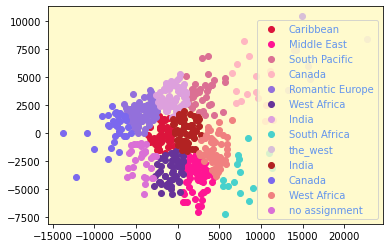

In [ ]:
for i in range(13): 
  plt.scatter(kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:,0] , kmeans_df.loc[kmeans_df.cluster_assignment == i].iloc[:, 1] , color = colors[i], label = clust_pca_assignment_dict[i])
plt.legend()
plt.show()

In [ ]:
tuple(clust_pca_assignment_dict[i] for i in range(13))

('Caribbean',
 'Middle East',
 'South Pacific',
 'Canada',
 'Romantic Europe',
 'West Africa',
 'India',
 'South Africa',
 'the_west',
 'India',
 'Canada',
 'West Africa',
 'no assignment')